In [1]:
import numpy as np
import matplotlib.pyplot as plt

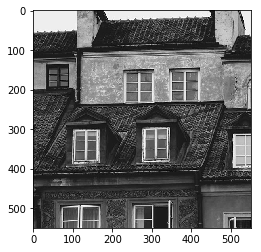

In [132]:
from PIL import Image, ImageDraw
import requests

url = 'https://www.worldgbc.org/sites/default/files/Content%20pages%20old%20europe%20buildings.jpg'

img = Image.open(requests.get(url, stream=True).raw).convert('L')
img = np.array(img).astype(np.float64)[:, 400:950] / 255

plt.imshow(img, cmap='gray')

In [133]:
X_orig = img

In [134]:
def f(x, b):
    return np.sum((x - b) ** 2)

def grad_f(x):
    b = X_orig.copy().reshape(-1)
    return 2 * (x - b) 

In [274]:
def A(X):
    return X.reshape(-1)

def A_star(x):
    return x.reshape(X_orig.shape)

In [275]:
X_0 = X_orig.copy()

In [278]:
err = []

In [279]:
from scipy.sparse import linalg as slin
from tqdm import tqdm

class Sketch:
    def __init__(self):
        self.Omega = None
        self.Psi = None
        self.Y = None
        self.W = None
        self.X_orig = None
        self.r = 0
    
    def init(self, X_orig, r):
        self.X_orig = X_orig.copy()
        self.r = r
        
        m, n = X_orig.shape
        
        k = 2 * r + 1
        l = 4 * r + 3
        
        self.Omega = np.random.randn(n, k)
        self.Psi = np.random.randn(l, m)
        
        self.Y = np.zeros((m, k))
        self.W = np.zeros((l, n))
        
    def CGMU_update(self, u, v, nu):
        self.Y = (1 - nu) * self.Y + nu * u @ (v.T @ self.Omega)
        self.W = (1 - nu) * self.W + nu * (self.Psi @ u) @ v.T
        
    def reconstruct(self):
        Q, _ = np.linalg.qr(self.Y)
                
        B = np.linalg.pinv(self.Psi @ Q) @ self.W
        
        U, S, V = np.linalg.svd(B, full_matrices=False)
                
        return Q @ U[:,:self.r], S[:self.r], V[:self.r,:]
    
    def factorize(self, num_iter=100, alpha = 1.0, eps=1e-17):
        z = np.ones(self.X_orig.shape).reshape(-1)
        
        alpha = 2.9 * np.trace(self.X_orig)
        
        for i in tqdm(range(num_iter)):
            u, _, v = np.linalg.svd(A_star(grad_f(z)))
            u = u[:,:1]
            v = v[:1,:].T
            
            h = A((-alpha * u @ v.T))
            e = (z - h) @ grad_f(z)
            
            err.append(e)
            if np.abs(e) <= eps :
                break
            
            nu = 2 / (i + 2)
            z = (1 - nu) * z + nu * h
            self.CGMU_update(-alpha * u, v, nu)

In [280]:
err = []
sketch = Sketch()
sketch.init(X_0, 550)
sketch.factorize()
U, S, V = sketch.reconstruct()

100%|██████████| 100/100 [00:08<00:00, 11.42it/s]


36


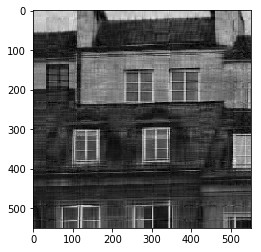

In [281]:
X_rec = U @ np.diag(S) @ V

print(np.linalg.matrix_rank(X_rec))

plt.imshow(X_rec, cmap='gray')

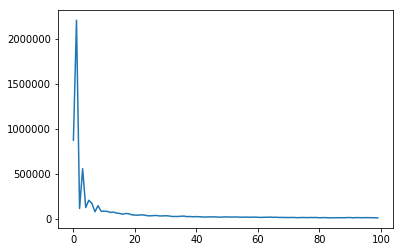

In [283]:
plt.plot(err)